analysis borrowed from pymc3 tutorial https://docs.pymc.io/notebooks/getting_started.html

In [7]:
import numpy as np
import pylab

In [8]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

In [9]:
# Size of dataset
size = 100

In [10]:
# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

In [11]:
# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

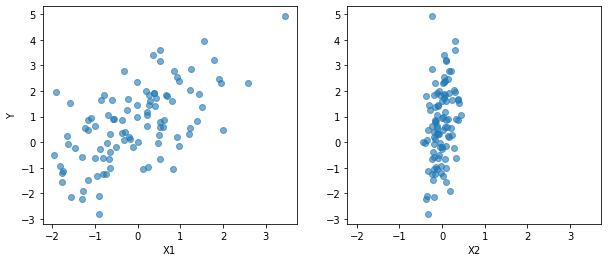

In [12]:
fig, axes = pylab.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [13]:
import pymc3 as pm

In [14]:
basic_model = pm.Model()

In [15]:
with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [16]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.816975),
 'beta': array([0.88493449, 2.85108301]),
 'sigma_log__': array(0.00951106),
 'sigma': array(1.00955643)}

In [17]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 20 seconds.


In [18]:
trace["alpha"][-5:]

array([0.91558076, 0.96030015, 0.93102421, 0.68015086, 0.94947365])

In [19]:
import arviz as az

In [20]:
az.style.use("arviz-darkgrid")

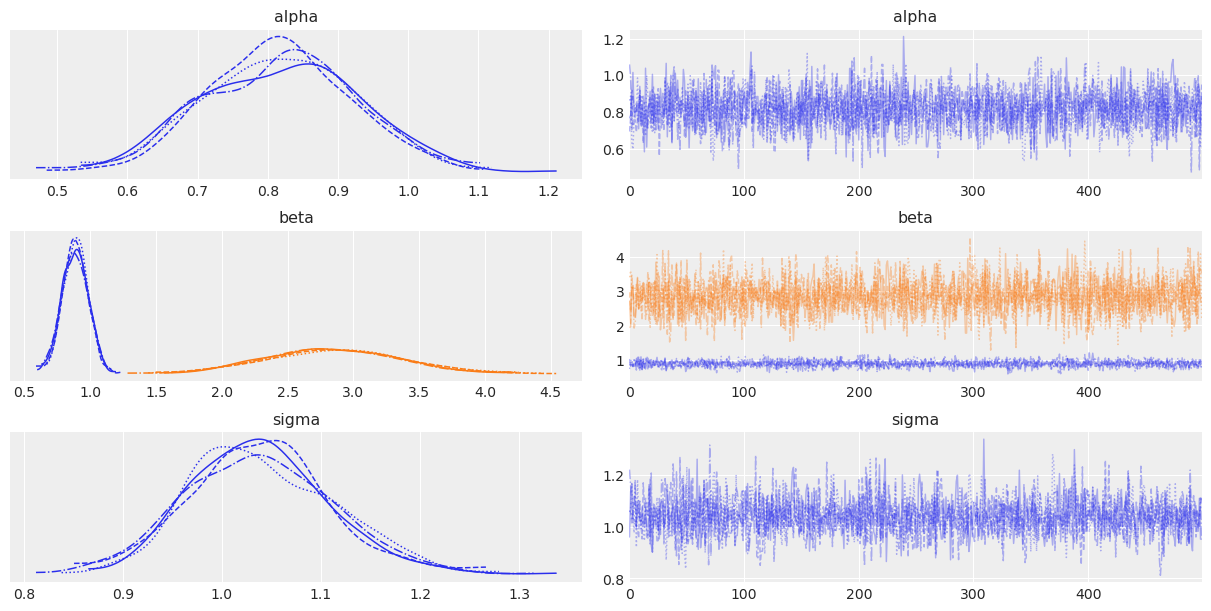

In [21]:
with basic_model:
    az.plot_trace(trace)

In [22]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.82,0.11,0.63,1.02,0.00,0.00,2977.35,2923.73,2977.05,1493.38,1.0
beta[0],0.89,0.10,0.70,1.06,0.00,0.00,3329.04,3329.04,3304.00,1589.48,1.0
beta[1],2.85,0.51,1.88,3.76,0.01,0.01,2656.07,2487.04,2696.43,1293.50,1.0
sigma,1.04,0.07,0.91,1.19,0.00,0.00,2503.69,2477.33,2524.60,1534.85,1.0


In [30]:
import pandas as pd

In [31]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

In [32]:
# fmt: on
years = np.arange(1851, 1962)

Text(0.5, 0, 'Year')

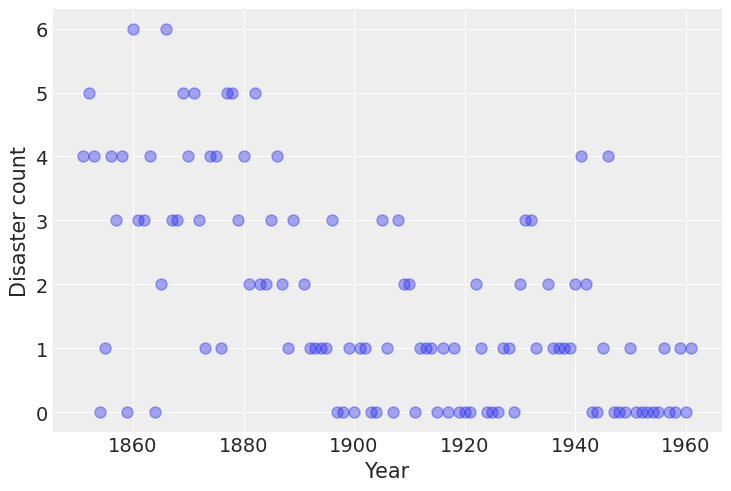

In [33]:
pylab.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
pylab.ylabel("Disaster count")
pylab.xlabel("Year")

In [38]:
with pm.Model() as disaster_model:
    # Priors for rate number of disasters
    rate = pm.Exponential("rate", 1.0)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/Users/arjunchandrasekhar/opt/anaconda3/envs/cmpinf2120/lib/python3.9/site-packages/pymc3/model.py:1668: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [39]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rate]
>Metropolis: [disasters_missing]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


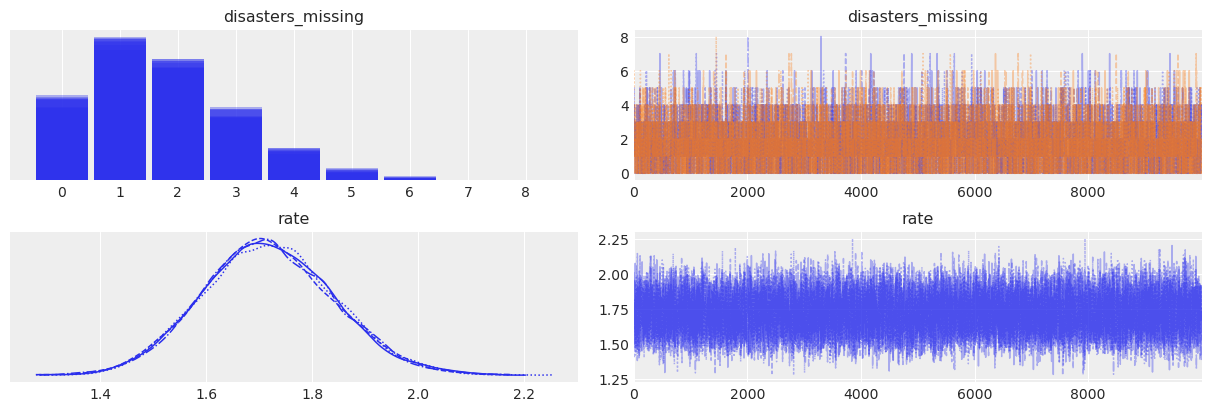

In [43]:
with disaster_model:
    az.plot_trace(trace)

In [44]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/Users/arjunchandrasekhar/opt/anaconda3/envs/cmpinf2120/lib/python3.9/site-packages/pymc3/model.py:1668: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [45]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.
The number of effective samples is smaller than 10% for some parameters.


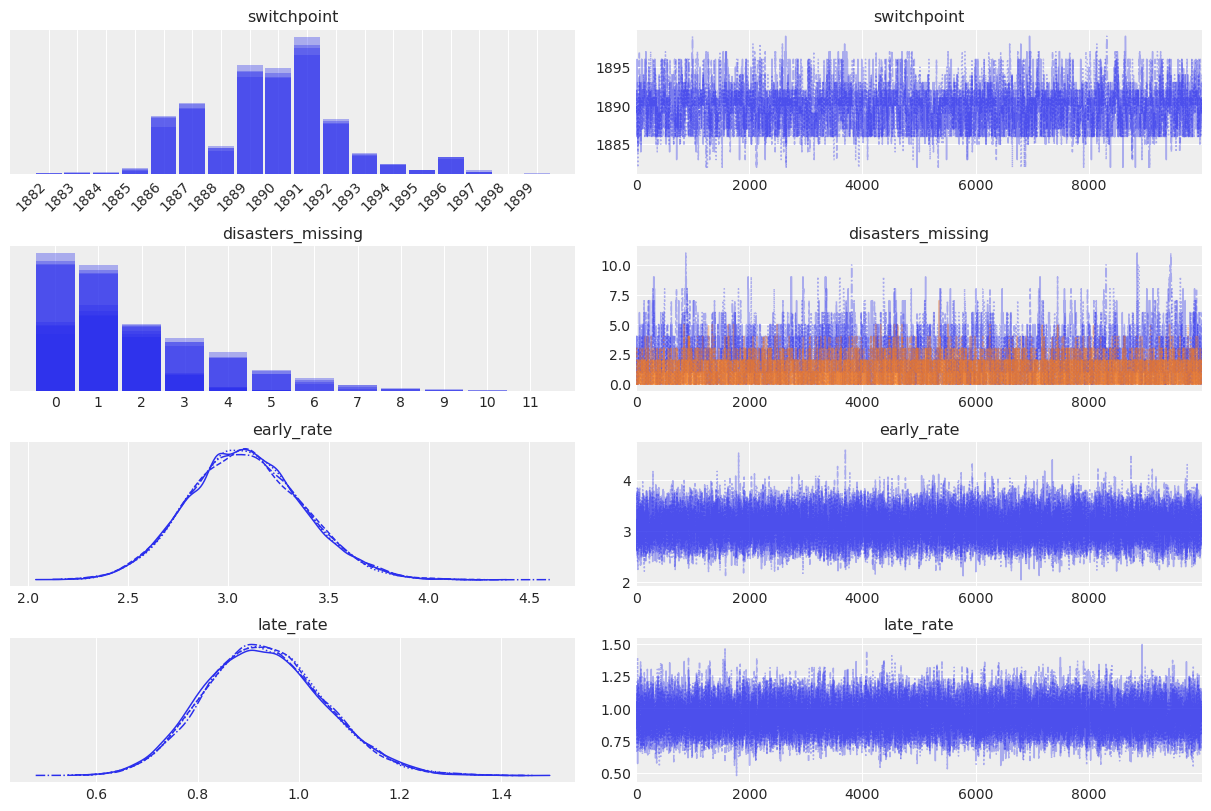

In [51]:
with disaster_model:
    axes_arr = az.plot_trace(trace)
pylab.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
pylab.draw()